In [16]:
from q_lib import Q_learner,run_sim_Q, Q_asym, run_sim_Q_Asym
from WoLF_lib import WoLF_PHC, run_sim_wolf,WoLF_PHC_asym, run_sim_wolf_asym
from JAL_AM_lib import JAL_AM, run_sim_JAL_AM, JAL_AM_asym, run_sim_JAL_AM_asym, edge_or_focal, edge_or_focal_asym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import tqdm
import seaborn as sns
from numba import njit

# Baseline

In [2]:
def run_all_sim(n,k, progress=True):
    """
    args:
        alpha: step-size parameter
        gamma: discount factor
        delta_l:
        delta_w:
        k: length of price action vector
        T: number of total simulations
        n: number of runs simulated
    returns:
        JAL_AM_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for JAL-AM
        Q_learner_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for Q-learning
        WoLF_PHC_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for WoLF-PHC
    """
    avg_prof_JAL_AM, avg_prof_gain_JAL_AM, edge_JAL_AM, focal_JAL_AM = run_sim_JAL_AM(n, k, progress)
    JAL_AM_res = [avg_prof_JAL_AM, avg_prof_gain_JAL_AM, edge_JAL_AM, focal_JAL_AM]

    avg_prof_Q, avg_prof_gain_Q, edge_Q, focal_Q = run_sim_Q(n, k, progress)
    Q_res = [avg_prof_Q, avg_prof_gain_Q, edge_Q, focal_Q]

    avg_prof_WoLF_PHC, avg_prof_gain_WoLF_PHC, edge_WoLF_PHC, focal_WoLF_PHC = run_sim_wolf(n, k, progress)
    WoLF_PHC_res = [avg_prof_WoLF_PHC, avg_prof_gain_WoLF_PHC, edge_WoLF_PHC, focal_WoLF_PHC]

    return JAL_AM_res,Q_res,WoLF_PHC_res

In [3]:
JAL_AM_res,Q_res,WoLF_PHC_res = run_all_sim(1000, np.linspace(0,1, 7))

WoLF-PHC: 100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


In [4]:
JAL_AM_res24,Q_res24,WoLF_PHC_res24 = run_all_sim(1000, np.linspace(0,1, 25))

WoLF-PHC: 100%|██████████| 1000/1000 [06:42<00:00,  2.48it/s]


### Profitability graph

In [3]:
def plot_profitability(t, k, JAL_AM_res, Q_learner_res, WoLF_PHC_res, mu=0, baseline=True):
    fig, axs = plt.subplots(1, 1, figsize=(10,7))
    if baseline:
        fig.suptitle("Average profitability for all in {} different runs, k={}".format(t, k-1))
    else: 
        fig.suptitle("Average profitability for all in {} different runs, k={}, $\mu$={}".format(t, k-1, mu))
    axs.set_xlabel("t")
    axs.set_ylabel("profitability")
    xs = np.linspace(0, 500000, 499)
    axs.set_ylim(0.05,0.125+(0.125*0.05))
    axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='black', linestyles='dashed', label='Joint profit maximizing')
    axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='grey', linestyles='dashed', label='Comp Benchmark')
    if baseline:
        axs.plot(xs, JAL_AM_res[0], color="steelblue", label = "JAL-AM")
        axs.plot(xs, Q_learner_res[0], color="C3", label = "Q-learning")
        axs.plot(xs, WoLF_PHC_res[0], color="g", label = "WoLF-PHC")
    else:
        axs.plot(xs, JAL_AM_res[0], color="steelblue", label = "JAL-AM asym")
        axs.plot(xs, Q_learner_res[0], color="C3", label = "Q-learning asym")
        axs.plot(xs, WoLF_PHC_res[0], color="g", label = "WoLF-PHC asym")
    axs.legend()  # Show the legend to display the label of the newly added line
    if baseline:
        plt.savefig(f'Graphs/baseline_prof_k{k}.png')
    else: 
        plt.savefig(f'Graphs/asym_prof_k{k}_mu{mu}.png')
    plt.show()

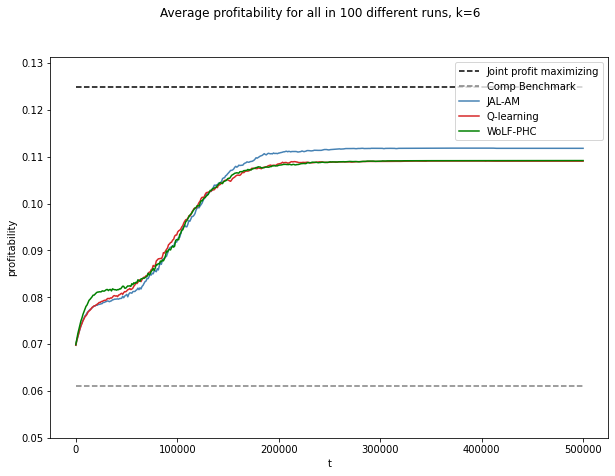

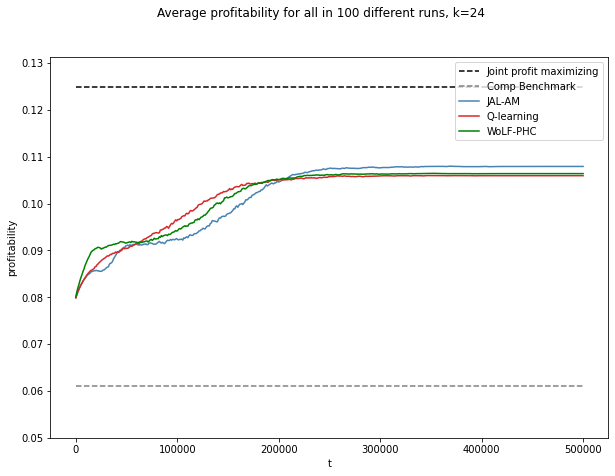

In [6]:
plot_profitability(100, 7, JAL_AM_res, Q_res, WoLF_PHC_res, 0)
plot_profitability(100, 25, JAL_AM_res24, Q_res24, WoLF_PHC_res24, 0)

In [7]:
print("Profitability JAL-AM (k=6):      ", JAL_AM_res[0][498])
print("Profitability Q-learning (k=6):  ", Q_res[0][498])
print("Profitability WoLF-PHC (k=6):    ", WoLF_PHC_res[0][498])

print("Profitability JAL-AM (k=24):     ", JAL_AM_res24[0][498])
print("Profitability Q-learning (k=24): ", Q_res24[0][498])
print("Profitability WoLF-PHC (k=24):   ", WoLF_PHC_res24[0][498])


Profitability JAL-AM (k=6):       0.11181036111111266
Profitability Q-learning (k=6):   0.10906875000000131
Profitability WoLF-PHC (k=6):     0.10919673611111261
Profitability JAL-AM (k=24):      0.10794125520833334
Profitability Q-learning (k=24):  0.1059676475694442
Profitability WoLF-PHC (k=24):    0.1064114010416667


### Avg. profit gain graph

In [4]:
# Function to count values in each interval
def count_intervals(data, intervals):
    counts = np.zeros(len(intervals), dtype=int)
    for num in data:
        for i, interval in enumerate(intervals):
            if interval[0] < num <= interval[1]:
                counts[i] += 1
    return counts

In [5]:
def plot_avg_prof_gain(data1, data2, intervals, labels, algo, k_val, mu=0, baseline=True):
    # Plot the counts for each interval of an algorithm
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(intervals))
    bar1 = plt.bar(index - bar_width/2, data1, bar_width, label= f'k={k_val[0]}')
    bar2 = plt.bar(index + bar_width/2, data2, bar_width, label=f'k={k_val[1]}')
    
    plt.xticks(index, labels, rotation=45, ha='right')
    plt.xlabel('Δ')
    plt.ylabel('Frequency')
    if baseline:
        plt.title(f'Distribution of Avg. Profit Gain for {algo}')
    else:
        plt.title(f'Distribution of Avg. Profit Gain for {algo} under asymmetric information, $\mu$={mu}')
    plt.legend()
    plt.tight_layout()
    if baseline:
        plt.savefig(f'Graphs/avg_prof_gain_{algo}.png')
    else:
        plt.savefig(f'Graphs/avg_prof_gain_{algo}_asym.png')
    plt.show()

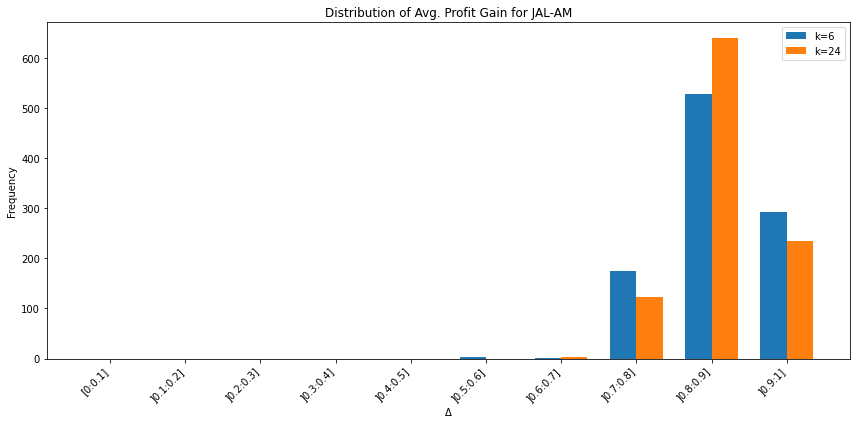

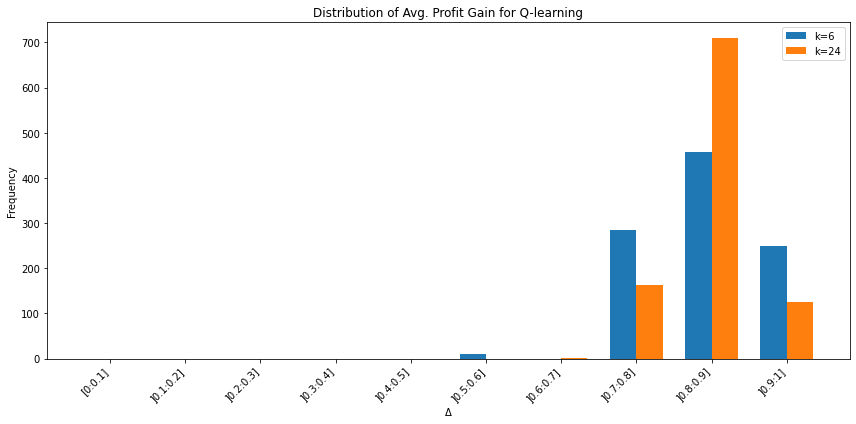

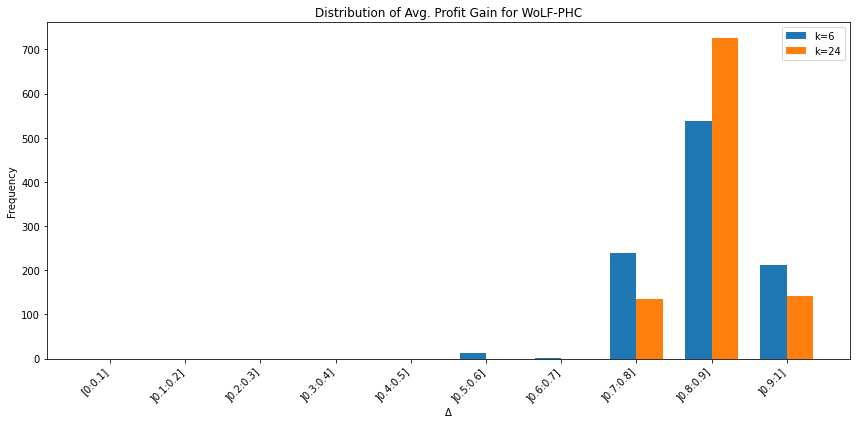

In [10]:
# Define the intervals
intervals = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0:0.1]',']0.1:0.2]',']0.2:0.3]', ']0.3:0.4]', ']0.4:0.5]', ']0.5:0.6]', ']0.6:0.7]', ']0.7:0.8]', ']0.8:0.9]', ']0.9:1]']

JAL_AM_prof_gain_k6 = count_intervals(JAL_AM_res[1], intervals)
JAL_AM_prof_gain_k24 = count_intervals(JAL_AM_res24[1], intervals)
plot_avg_prof_gain(JAL_AM_prof_gain_k6, JAL_AM_prof_gain_k24, intervals, intervals_str, 'JAL-AM', [6, 24])

Q_prof_gain_k6 = count_intervals(Q_res[1], intervals)
Q_prof_gain_k24 = count_intervals(Q_res24[1], intervals)
plot_avg_prof_gain(Q_prof_gain_k6, Q_prof_gain_k24, intervals, intervals_str, 'Q-learning', [6, 24])

WoLF_PHC_prof_gain_k6 = count_intervals(WoLF_PHC_res[1], intervals)
WoLF_PHC_prof_gain_k24 = count_intervals(WoLF_PHC_res24[1], intervals)
plot_avg_prof_gain(WoLF_PHC_prof_gain_k6, WoLF_PHC_prof_gain_k24, intervals, intervals_str, 'WoLF-PHC', [6, 24])

### Edgeworth price cycles & focal pricing

In [40]:
def plot_edge_focal(edgeworth_data, focal_data, k, mu, baseline=True):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Define the positions for the groups
    index = np.arange(2)  # We have two categories
    bar_width = 0.2  # Width of each bar
    # Define the positions for each bar in the group
    positions_JAL_AM = index - bar_width
    positions_Q = index
    positions_WoLF_PHC = index + bar_width
    # Plotting
    bar1 = ax.bar(positions_JAL_AM[0], edgeworth_data[0], bar_width, label='JAL-AM', color='steelblue')
    bar2 = ax.bar(positions_Q[0], edgeworth_data[1], bar_width, label='Q-learning', color='C3')
    bar3 = ax.bar(positions_WoLF_PHC[0], edgeworth_data[2], bar_width, label='WoLF-PHC', color='g')

    bar4 = ax.bar(positions_JAL_AM[1], focal_data[0], bar_width, label='JAL-AM',color='steelblue')
    bar5 = ax.bar(positions_Q[1], focal_data[1], bar_width, label='Q-learning', color='C3')
    bar6 = ax.bar(positions_WoLF_PHC[1], focal_data[2], bar_width, label='WoLF-PHC', color='g')

    # Labels and title
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Frequency')
    if baseline:
        ax.set_title(f'Distribution of Edgeworth Price Cycles and Focal Pricing, k={k}')
    else:
        ax.set_title(f'Distribution of Edgeworth Price Cycles and Focal Pricing, k={k}, mu={mu}')
    ax.set_xticks(index)
    ax.set_xticklabels(['Edgeworth Price Cycles', 'Focal Pricing'])
    ax.legend(['JAL-AM', 'Q-learning', 'WoLF-PHC'])

    # Display the plot
    plt.tight_layout()
    if baseline:
        plt.savefig(f'Graphs/edgeworth_focal_k{k}.png')
    else:
        plt.savefig(f'Graphs/edgeworth_focal_asym_k{k}_mu{mu}.png')
    plt.show()

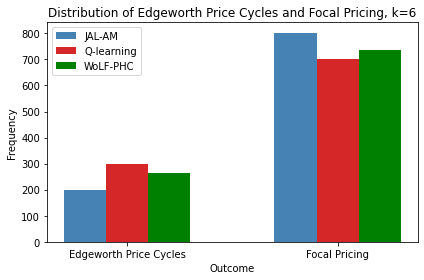

In [12]:
edgeworth_data = [JAL_AM_res[2], Q_res[2], WoLF_PHC_res[2]]
focal_data = [JAL_AM_res[3], Q_res[3], WoLF_PHC_res[3]]

plot_edge_focal(edgeworth_data, focal_data, 6)

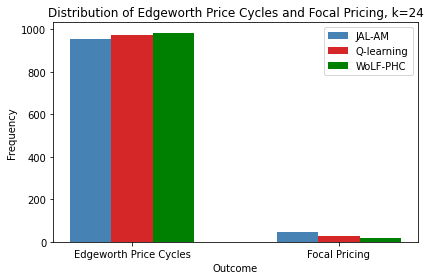

In [13]:
edgeworth_data24 = [JAL_AM_res24[2], Q_res24[2], WoLF_PHC_res24[2]]
focal_data24 = [JAL_AM_res24[3], Q_res24[3], WoLF_PHC_res24[3]]

plot_edge_focal(edgeworth_data24, focal_data24, 24)

# Asymmetric information

In [7]:
def run_all_sim_asym(n, k, mu, progress=True):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        JAL_AM_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for JAL-AM
        Q_learner_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for Q-learning
        WoLF_PHC_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for WoLF-PHC
    """
    avg_prof_JAL_AM, avg_prof_gain_JAL_AM, edge_JAL_AM, focal_JAL_AM = run_sim_JAL_AM_asym(n, k, mu, progress)
    JAL_AM_res = [avg_prof_JAL_AM, avg_prof_gain_JAL_AM, edge_JAL_AM, focal_JAL_AM]

    avg_prof_Q, avg_prof_gain_Q, edge_Q, focal_Q = run_sim_Q_Asym(n, k, mu, progress)
    Q_res = [avg_prof_Q, avg_prof_gain_Q, edge_Q, focal_Q]

    avg_prof_WoLF_PHC, avg_prof_gain_WoLF_PHC, edge_WoLF_PHC, focal_WoLF_PHC = run_sim_wolf_asym(n, k, mu, progress)
    WoLF_PHC_res = [avg_prof_WoLF_PHC, avg_prof_gain_WoLF_PHC, edge_WoLF_PHC, focal_WoLF_PHC]

    return JAL_AM_res,Q_res,WoLF_PHC_res, n, k, mu

In [8]:
JAL_AM_res_asym,Q_learner_res_asym, WoLF_PHC_res_asym, n, k, mu = run_all_sim_asym(1000, np.linspace(0,1,7), 0.05)

In [9]:
JAL_AM_res_asym24,Q_learner_res_asym24, WoLF_PHC_res_asym24, nn, k24, mu = run_all_sim_asym(1000, np.linspace(0,1,25), 0.05)

## Profitability

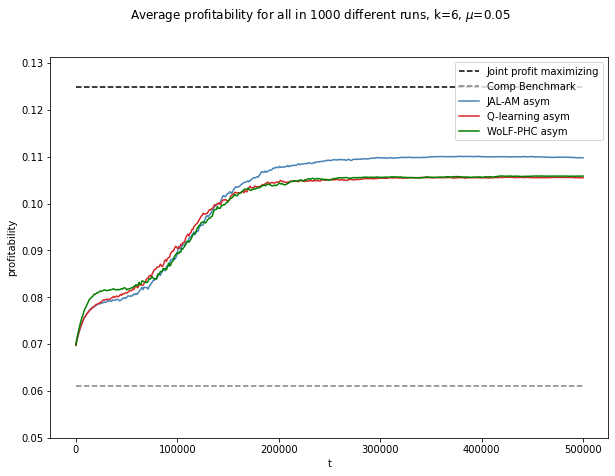

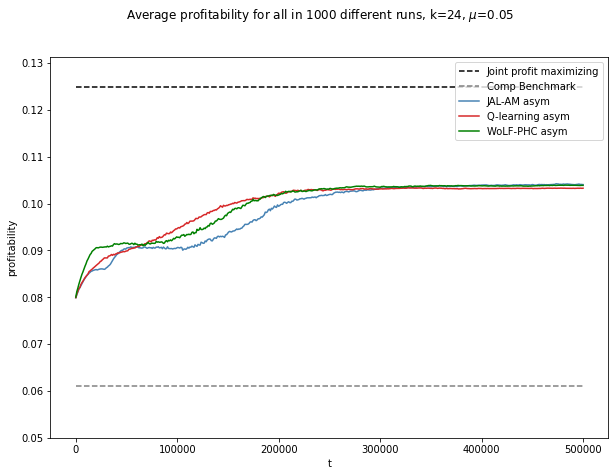

In [10]:
plot_profitability(n, len(k), JAL_AM_res_asym, Q_learner_res_asym, WoLF_PHC_res_asym,mu=mu, baseline=False)
plot_profitability(nn, len(k24), JAL_AM_res_asym24, Q_learner_res_asym24, WoLF_PHC_res_asym24, mu=mu, baseline=False)

## Average profit gain

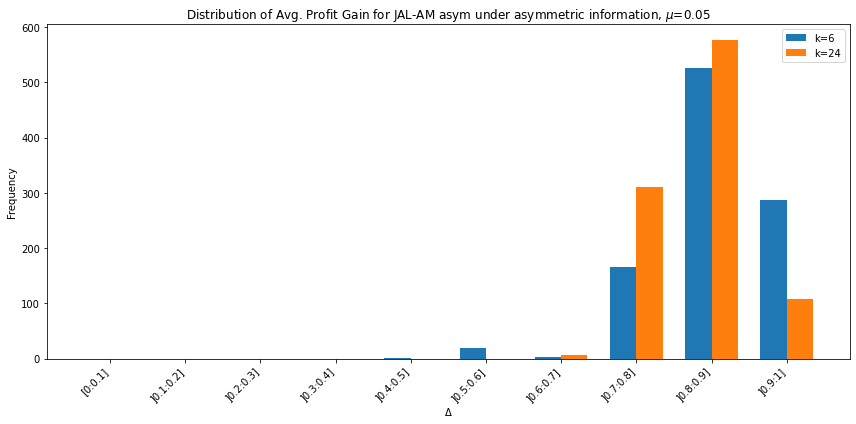

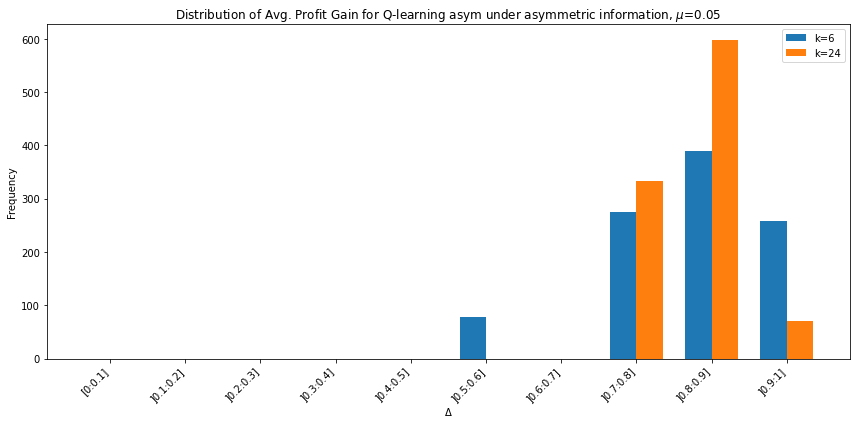

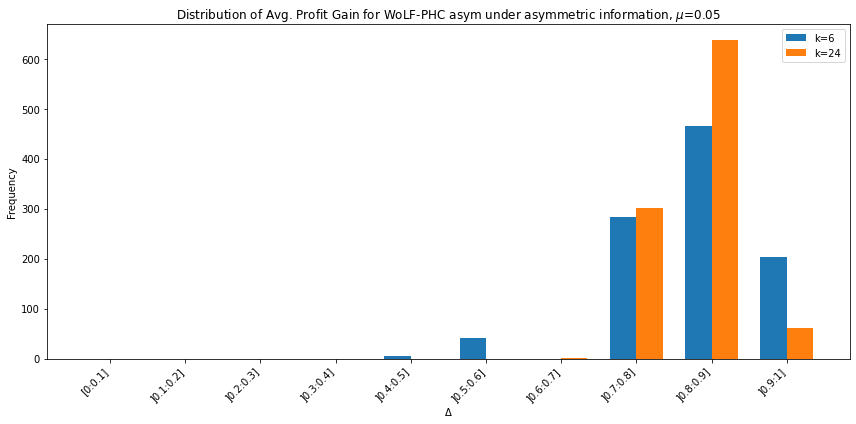

In [11]:
# Define the intervals
intervals = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0:0.1]',']0.1:0.2]',']0.2:0.3]', ']0.3:0.4]', ']0.4:0.5]', ']0.5:0.6]', ']0.6:0.7]', ']0.7:0.8]', ']0.8:0.9]', ']0.9:1]']

JAL_AM_prof_gain_k6 = count_intervals(JAL_AM_res_asym[1], intervals)
JAL_AM_prof_gain_k24 = count_intervals(JAL_AM_res_asym24[1], intervals)
plot_avg_prof_gain(JAL_AM_prof_gain_k6, JAL_AM_prof_gain_k24, intervals, intervals_str, 'JAL-AM asym', [6, 24], mu=mu, baseline=False)

Q_prof_gain_k6 = count_intervals(Q_learner_res_asym[1], intervals)
Q_prof_gain_k24 = count_intervals(Q_learner_res_asym24[1], intervals)
plot_avg_prof_gain(Q_prof_gain_k6, Q_prof_gain_k24, intervals, intervals_str, 'Q-learning asym', [6, 24], mu=mu, baseline=False)

WoLF_PHC_prof_gain_k6 = count_intervals(WoLF_PHC_res_asym[1], intervals)
WoLF_PHC_prof_gain_k24 = count_intervals(WoLF_PHC_res_asym24[1], intervals)
plot_avg_prof_gain(WoLF_PHC_prof_gain_k6, WoLF_PHC_prof_gain_k24, intervals, intervals_str, 'WoLF-PHC asym', [6, 24], mu=mu, baseline=False)

## Edgeworth price cycles or focal pricing

In [17]:
from JAL_AM_lib import edge_or_focal_asym

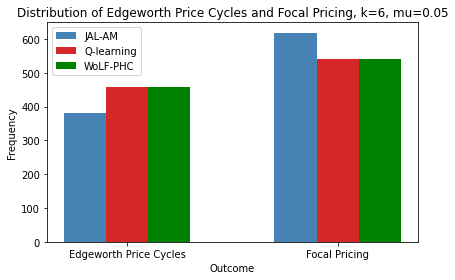

In [41]:
edgeworth_data = [JAL_AM_res_asym[2], Q_learner_res_asym[2], WoLF_PHC_res_asym[2]]
focal_data = [JAL_AM_res_asym[3], Q_learner_res_asym[3], WoLF_PHC_res_asym[3]]

plot_edge_focal(edgeworth_data, focal_data, 6, mu, False)

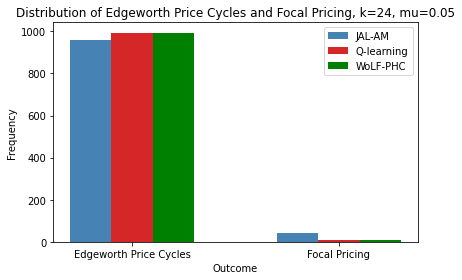

In [43]:
edgeworth_data = [JAL_AM_res_asym24[2], Q_learner_res_asym24[2], WoLF_PHC_res_asym24[2]]
focal_data = [JAL_AM_res_asym24[3], Q_learner_res_asym24[3], WoLF_PHC_res_asym24[3]]

plot_edge_focal(edgeworth_data, focal_data, 24, mu, False)

In [37]:
p_t, avgp1, avgp2 = Q_asym(0.3, 0.95, 500000,np.linspace(0,1,7), 0.1)

In [38]:
edge_or_focal_asym(0, 0, p_t,0.2, 50)

(0, 1, True)

In [39]:
p_t[:,-50:]

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.33333333, 0.33333333, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.5       ,
        0.5       , 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.1

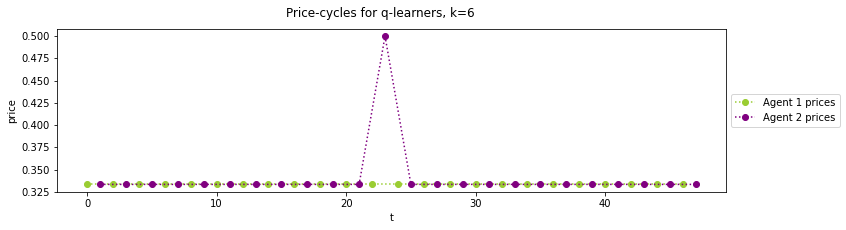

In [25]:
p1 = p_t[0,-50:]
p2 = p_t[1,-50:]

plt.figure(figsize=(12, 3))
p0s2d = p1[np.arange(0, p1.size, 2)][:-1]
p1s2d = p2[np.arange(1, p2.size, 2)][:-1]

plt.xlabel("t")
plt.ylabel("price")
plt.suptitle("Price-cycles for q-learners, k=6")

plt.plot(range(0, 48, 2), p0s2d , label="Agent 1 prices", marker="o", color="yellowgreen", linestyle="dotted")
plt.plot(range(1, 48, 2), p1s2d, label="Agent 2 prices", marker="o", color="purple", linestyle="dotted")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Heatmap, robustness in k and $\mu$

In [44]:
def heatmap_sim(k_values, mu_values, T, algo):
    # Prepare a matrix to store results
    heatmap_data = np.zeros((len(mu_values), len(k_values)))
    # Calculate the total number of iterations
    total_iterations = len(mu_values) * len(k_values)
    # Run simulations and collect data
    with tqdm(total=total_iterations, desc="Simulating", unit="iteration") as pbar:
        for i, mu in enumerate(mu_values):
            for j, k in enumerate(k_values):
                if algo == 'Q-learning':
                    avg_prof_asymm, avg_prof_gain, edge_asymm, focal_asymm = run_sim_Q_Asym(T, np.linspace(0, 1, k+1), mu) # Det er nok hurtigere bare at give k+1 også lave linspace inde i funktionen
                elif algo == 'JAL-AM':
                    avg_prof_asymm, avg_prof_gain, edge_asymm, focal_asymm = run_sim_JAL_AM_asym(T, np.linspace(0, 1, k+1), mu)
                elif algo == 'WoLF-PHC': 
                    avg_prof_asymm, avg_prof_gain, edge_asymm, focal_asymm = run_sim_wolf_asym(T, np.linspace(0, 1, k+1), mu)
                heatmap_data[i, j] = avg_prof_asymm[498]  # Or any other metric you want to plot
                # Update the progress bar
                pbar.update(1)
    return heatmap_data


In [45]:
def plot_heatmap(heatmap_data, k_values, mu_values, algo):
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, xticklabels=k_values, yticklabels=mu_values, cmap="YlGnBu", fmt=".4f", annot=True)
    ax.invert_yaxis()
    plt.title("Profitability for a grid of values of k and $\mu$")
    plt.xlabel("k")
    plt.ylabel("$\mu$")
    plt.savefig(f'Graphs/heatmap_{algo}.png')
    plt.show()

In [34]:
# Values for k and mu
k_values = [6, 12, 18, 24, 30, 36]
mu_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

Simulating: 100%|██████████| 66/66 [01:17<00:00,  1.17s/iteration]


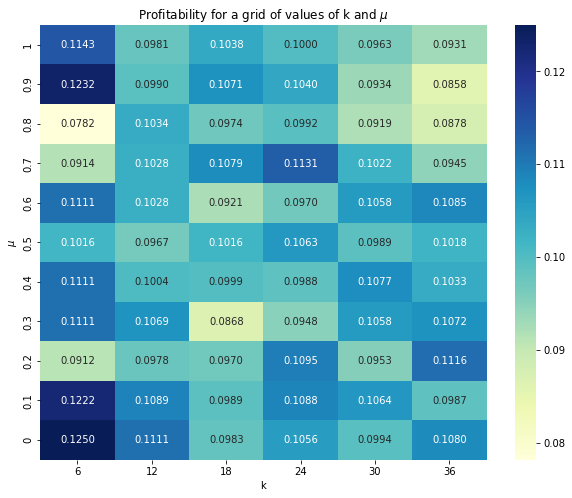

In [ ]:
heatmap_data_JAL_AM = heatmap_sim(k_values, mu_values, 1000, 'JAL-AM')
heatmap_data_Q = heatmap_sim(k_values, mu_values, 1000, 'Q-learning')
heatmap_data_wolf = heatmap_sim(k_values, mu_values, 1000, 'WoLF-PHC')

In [ ]:
plot_heatmap(heatmap_data_JAL_AM, k_values, mu_values, 'JAL-AM')
plot_heatmap(heatmap_data_Q, k_values, mu_values, 'Q-learning')
plot_heatmap(heatmap_data_wolf, k_values, mu_values, 'WoLF-PHC')